# Oscilador armónico unidimesional con el Método de Monte Carlo

## Modelo

Consideramos un oscilador armónico de una dimensión con un espectro de energía dado por:

$E_n = \hbar \omega (n+1/2)$

Para su resolución se utilizará el proceso de Markov que considera que cada estado microscópico sólo depende del último estado y no de los visitados anteriormente. Adicionalmente, se tiene la Condición de Balance Detallado (CBR) descrita a continuación.

$W(q' \rightarrow q)P_{eq}(q')-W(q \rightarrow q')P_{eq}(q)=0$

A partir de esto, podemos utilizar el algoritmo de Metrópolis para aplicar el método de Monte Carlo a nuestro sistema. 

## Aplicación

Definimos librerías a utilizar

In [1]:
#######################################################
import numpy as np                  # Libreria numpy ##
from numba import jit, njit, prange # Libreria numba ##
from math import exp                # importar exp ####
#######################################################

definición de la función que moverá nuestro estado adelante o atrás $n \rightarrow n' = \pm 1$ con probabilidad uniforme.

In [2]:
@jit
def E(it, beta, n, hw, cont):
    En = hw*(n + 0.5) #energia inicial
    E = np.zeros(it)
    for i in range (it):
        nprima = n + np.random.choice([-1,1]) #estado n'
    
        if nprima < 0:
            nprima = n + 1.
        else:
            nprima = nprima
        
        Enp = hw*(nprima + 0.5) #energia para estado n'
        DE = Enp - En #delta de energia
        if DE <= 0:
            n = nprima
            En = Enp

        elif DE > 0:
            zeta = np.random.random_sample() #numero random entre 0,1
            alfa = zeta - np.exp(-beta*DE)
            if alfa >= 0:
                n = n
            elif alfa < 0:
                n = nprima
                En = Enp
    
        E[i] = En
#        if i%200000 == 0:
#            print ('van', i  ,'iteraciones')
    
    return E

Definición de la variables a utilizar

In [3]:
hw = 1. 
k = 1.
T = 100. #Temperatura
beta = 1./(k*T)
n = 50. #estado inicial
it = 2500000 #numero de iteraciones
cont = 0
Energy = E(it, beta, n, hw, cont) #array con las energias en cada monte carlo step (MCS)

Cálculo de la energía promedio y fluctuación

In [4]:
@njit(parallel=True)
def Mean12_Evaluate(arr): #funcion que toma la energia promedio HASTA cada MCS
#    print len(arr)
    Resultado1 = np.zeros(len(arr))
    Resultado2 = np.zeros(len(arr))
    Resultado = np.zeros((2,len(arr)))
    arr2 = np.zeros(len(arr))
    
    arr2[:] = arr[:]**2
    for ii in prange (1,len(arr)):
        Resultado1[ii] = np.mean(arr[:ii])
        Resultado2[ii] = np.mean(arr2[:ii])
#        if ii%100000 == 0:
#            print 'van', ii, 'iteraciones'
    Resultado[0,:] = Resultado1[:]
    Resultado[1,:] = Resultado2[:] 
    return Resultado

In [5]:
#Definicion de arrays
E2 = np.zeros(it)
Eprom = np.zeros(it)
E2prom = np.zeros(it)
Eprom2 = np.zeros(it)
Sigma = np.zeros(it)

#calculo de promedios y fluctuaciones
Variables = Mean12_Evaluate(Energy)  
Eprom[:] = Variables[0,:]       #energia promedio hasta cada MCS   
E2prom[:] = Variables[1,:]      #energia al cuadrado promedio hasta cada MCS
Eprom2[:] = Eprom[:]**2         #energia promedio hasta cada MCS al cuadrado
Sigma[:] = E2prom[:]-Eprom2[:]  #fluctuacion

### Gráficos

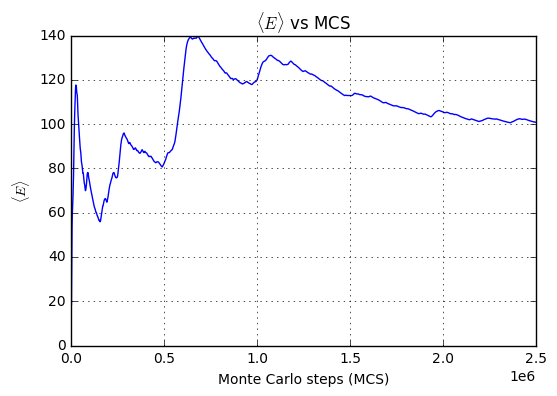

El valor del ultimo MCS es: 100.835010134


In [18]:
import matplotlib.pyplot as plt

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(np.linspace(0,len(Eprom[:]),len(Eprom[:])), Eprom[:])
plt.ylabel(r'$\langle E \rangle$')
plt.xlabel('Monte Carlo steps (MCS)')
plt.title(r'$\langle E \rangle$ vs MCS')
plt.grid(True)
plt.show()
print 'El valor del ultimo MCS es:', Eprom[-1:][0]

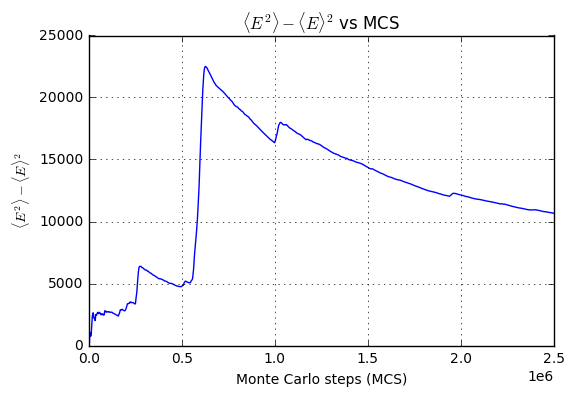

El valor del ultimo MCS es: 10659.7000133


In [19]:
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(np.linspace(0,len(Sigma[:]),len(Sigma[:])), Sigma[:])
plt.ylabel(r'$\langle E^2 \rangle - \langle E \rangle^2$')
plt.xlabel('Monte Carlo steps (MCS)')
plt.title(r'$\langle E^2 \rangle - \langle E \rangle^2$ vs MCS')
plt.grid(True)
plt.show()
print 'El valor del ultimo MCS es:', Sigma[-1:][0]

## Comparación con valor "exacto"

Ahora compararemos nuestro resultado con el valor exacto dado por el ensemble canónico

$\langle\epsilon\rangle = \hbar\omega \left(\frac{1}{e^{\frac{\hbar\omega}{kT}}-1} + \frac{1}{2} \right)$

In [8]:
e = hw*((1/(exp(hw*beta)-1))+0.5)
print 'El valor exacto es =', e

El valor exacto es = 100.000833332


Podemos calcular además,

$\langle E^2 \rangle - \langle E \rangle^2 = kT^2 C_v$

$C_v = k \left( \frac{\hbar \omega}{kT} \right)^2 \frac{e^{\hbar\omega/kT}}{\left( e^{\beta\hbar\omega} -1 \right)^2}$

In [9]:
Cv = k*(hw*beta)**2 *exp(hw*beta)/((exp(hw*beta)-1)**2)
DeltaE = Cv*k*T**2
print r'El valor exacto de $\DeltaE$ es =', DeltaE

El valor exacto de $\DeltaE$ es = 9999.91666708
